In [5]:
import pprint
import folium
import pandas as pd
import numpy as np
import sklearn
import datetime as dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Predicting without weather data

In [123]:
police_data = pd.read_csv("../police_data.csv")

In [124]:
police_data['Time'] = pd.to_datetime(police_data['Time'],format="%H:%M")
police_data['Date'] = pd.to_datetime(police_data['Date'],format="%m/%d/%Y")

In [125]:
police_data = police_data[(police_data['Date'] > '2012-10-01') & (police_data['Date'] < '2017-10-27')]

new_pd = police_data[['Category', 'Date','Time','DayOfWeek','PdDistrict']]
new_pd['Hour'] = new_pd['Time'].dt.hour
new_pd['Month'] = new_pd['Date'].dt.month
new_pd['Hour_of_week'] = new_pd['Date'].dt.dayofweek * 24 + (new_pd['Hour'] + 1)
new_pd['DayOfWeek'] = new_pd['Date'].dt.dayofweek

# Categories to use, framing the data

We define two categories, burglary and fraud. These are chosen because we hypothesize that burglaries are very impacted by weather, while fraud is not, and we want to see if weather have any effect on these crimes.

We use balanced datasets, with 10000 samples in each. We chose balanced simply because otherwise we might well have way too many burglary incidents compared to fraud, or the other way around, which would skew our model and ultimately impact later predictions. 

We then combine the datasets to one dataframe, which we then again split into training and testing sets.

In [126]:
burglaries = new_pd[(new_pd['Category'] == 'BURGLARY')]
fraud = new_pd[(new_pd['Category'] == 'FRAUD')]

balanced_burglaries = burglaries.sample(10000, random_state=1)
balanced_fraud = fraud.sample(10000, random_state=1)
combined_set = pd.concat([balanced_burglaries,balanced_fraud],axis=0)
combined_set['PdDistrict'] = pd.factorize(combined_set['PdDistrict'])[0]

In [127]:
train, test = train_test_split(combined_set, test_size=0.2)

We drop the time and date columns.

In [128]:
X_train = train.drop(columns=['Category','Time','Date'])
y_train = train['Category']

X_test = test.drop(columns=['Category','Time','Date'])
y_test = test['Category']

We define a small function for testing models.

In [129]:
def test_model(model):
    model.fit(X_train, y_train)
    print(model.score(X_test,y_test))

# Preparing the models

We define two distinct random forest classifiers, base_rfc, which represents a default instance of the random forest classfier that SKLearn provides, and later on we define **improved_rfc**. On improved_rfc we perform a Randomized Search for best hyperparameters, so as to find the 'best' parameters for our model, without having the manually adjust these. **Beware that testing for parameters takes a while**, so we've included the results of the testing below in the dict 'dbest_params'. No need to actually perform the testing on the readers part. 

In [133]:
base_rfc = RandomForestClassifier()
test_model(base_rfc)

0.592


We define the parameters and different values to test with. These are chosen with speed in mind, as testing for parameters takes a while. We have tried to cover most sensible values. 

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [1,5,20,50,100,200,500]
min_samples_leaf = [1,5,20,50,100,200,500]
bootstrap = [True, False]

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [130]:
rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfc_random.fit(X_train, y_train)

NameError: name 'random_grid' is not defined

In [20]:
best_params = {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 2000, 'min_samples_split': 100, 'min_samples_leaf': 20, 'bootstrap': True}

In [42]:
dbest_params = {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000, 'min_samples_split': 100, 'min_samples_leaf': 20, 'bootstrap': True}

In [131]:
improved_rfc = RandomForestClassifier()
improved_rfc.set_params(**best_params);

In [132]:
test_model(improved_rfc)

0.64675


# Did testing for hyperparameters help?

Well yes, it did. base_rfc has accuracy of about 0.59 - 0.60, while our improved model is around 0.64. 
A small improvement but anything counts!

Now we are interesting in testing for features, or more accurately, testing for how many features we ideally use.
For this we use SKLearns Recursive feature elimination with cross-validation (or, RFECV). This way we contiously fit our model and remove a feature at each step, and cross validate along the way. The end result is a model fitted with the best amount of features, that also avoids overfitting due to cross-validation.
The impact on accuracy, however, is barely noticable and remains about 0.64. 

In [134]:
rfecv_pre = RFECV(estimator = improved_rfc, step=1, cv=StratifiedKFold(2),scoring='accuracy')

In [135]:
rfecv_pre.fit(X_train,y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20,
                                       min_samples_split=100,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=2000, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [ ]:
rfecv_pre.score(X_test, y_test)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_pre.grid_scores_) + 1), rfecv_pre.grid_scores_)
plt.show()

In [168]:
rfecv_pre.score(X_test, y_test)

0.6435

# With weather

In [117]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [136]:
weather_data = pd.read_csv("../weather_data.csv")
weather_data['date'] = pd.to_datetime(weather_data['date'],infer_datetime_format="%Y/%m/%d",format="%d/%m/%Y")
weather_data.dropna()
weather_data['date'] = weather_data['date'].dt.tz_localize(None)
weather_data['hour'] = weather_data['date'].dt.hour
weather_data['date'] = weather_data['date'].dt.date

new_pd['Date'] = new_pd['Date'].dt.date

We merge the two datasets and repeat the steps in the previous section.

In [137]:
new_df = pd.merge(new_pd,weather_data,how='left',left_on=['Date','Hour'], right_on=['date','hour'])
new_df = new_df.dropna()

In [138]:
burglaries = new_df[(new_df['Category'] == 'BURGLARY')]
fraud = new_df[(new_df['Category'] == 'FRAUD')]

The features 'weather' and 'PdDistrict' is again factorized to allow the classfier to utilize them.

In [139]:
balanced_burglaries = burglaries.sample(10000, random_state=1)
balanced_fraud = fraud.sample(10000, random_state=1)
combined_set = pd.concat([balanced_burglaries,balanced_fraud],axis=0)
combined_set['PdDistrict'] = pd.factorize(combined_set['PdDistrict'])[0]
combined_set['weather'] = pd.factorize(combined_set['weather'])[0]

In [140]:
train_weather, test_weather = train_test_split(combined_set, test_size=0.2)

In [141]:
X_train_weather = train_weather.drop(columns=['Category','Time','Date','date'])
y_train_weather = train_weather['Category']

X_test_weather = test_weather.drop(columns=['Category','Time','Date','date'])
y_test_weather = test_weather['Category']

# What features to use?

Instead of removing features we think may or may not work in regards to the weather, we once again turn to RFECV. 
Adding weather data means that we now have 11 features total, so performing the RFECV now takes a little longer. Again, for the readers sake, we've included the results below so no need to fit the RFECV.  

In [142]:
rfecv = RFECV(estimator = improved_rfc, step=1, cv=StratifiedKFold(2),scoring='accuracy')

In [143]:
rfecv.fit(X_train_weather,y_train_weather)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20,
                                       min_samples_split=100,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=2000, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Below is a small plot of how our accuracy changes according to features used. 5 is optimal and adding more lowers the accuracy.

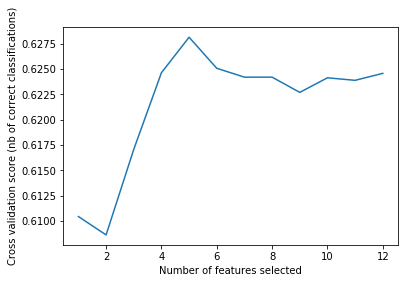

In [146]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [147]:
rfecv.score(X_test_weather,y_test_weather)

0.63125

In [167]:
improved_rfc.fit(X_train_weather, y_train_weather)
improved_rfc.score(X_test_weather, y_test_weather)

0.62625

In [169]:
base_rfc.fit(X_train_weather, y_train_weather)
base_rfc.score(X_test_weather, y_test_weather)

0.609

# Final results

To avoid having the user perform RFECV, here are the final results:

## Crime-data without weather:

Naive Random Forest Classifer (without finding best hyperparameters or performing RFECV:
~ 0.59

w. best hyperparameters:
~ 0.64

w. best hyperparameters and best features:
~ 0.64

## Crime-data with weather:

Naive Random Forest Classifer (without finding best hyperparameters or performing RFECV:
~ 0.6

w. best hyperparameters:
~ 0.62

w. best hyperparameters and best features:
~ 0.63

As it turns out, adding weather data to our original crime dataset did not improve accuracy. We can now make a somewhat educated guess and say that neither burglary nor fraud depends severely on the current weather situation.

But, we can predict what type of crime will take base on some relevant features, with about 64% accuracy. This is by no means perfect, but it's better than purely guessing.

In [163]:
ranks = rfecv.ranking_

In [164]:
features = X_test_weather.columns.to_numpy()

## What were the most significant features?

Here's the ranking, with lower being better. DayOfWeek scores worst and has little to no positive impact. Same goes for weather, wind speed and month. Temperature turned out to be relatively important, so did hour, police district and , surprisingly, wind direction.

* Ranking of DayOfWeek : 8
* Ranking of PdDistrict : 1
* Ranking of Hour : 1
* Ranking of Month : 5
* Ranking of Hour_of_week : 1
* Ranking of temperature : 1
* Ranking of humidity : 3
* Ranking of weather : 6
* Ranking of wind_speed : 7
* Ranking of wind_direction : 2
* Ranking of pressure : 4
* Ranking of hour : 1


In [166]:
for i in range(len(ranks)):
    print("Ranking of " + features[i] + " : " + str(ranks[i]))

Ranking of DayOfWeek : 8
Ranking of PdDistrict : 1
Ranking of Hour : 1
Ranking of Month : 5
Ranking of Hour_of_week : 1
Ranking of temperature : 1
Ranking of humidity : 3
Ranking of weather : 6
Ranking of wind_speed : 7
Ranking of wind_direction : 2
Ranking of pressure : 4
Ranking of hour : 1
